In [65]:
# encoding=utf-8
import os
import time
import re
import unicodedata
import traceback
import warnings
from typing import Callable
import importlib

from tqdm import tqdm
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fontTools.ttLib import TTFont

In [67]:
import utils
importlib.reload(utils)

from utils import fetch_font, LOG_DIRECTORY, LOG_SUFFIX, COLUMN_SEPARATOR, LogFile

In [7]:
fonts_dir = 'fonts'
font_size = 64
os.path.exists(fonts_dir)

True

In [16]:
font_list = []
file_list = os.listdir(fonts_dir)
for filename in file_list:
    child_path = os.path.join(fonts_dir, filename)

    if not os.path.isfile(child_path):
        warnings.warn(f'Skipping directory {child_path}!')
        continue

    file_ext = os.path.splitext(filename)[1]
    file_ext = file_ext.lower()

    if (file_ext == '.ttf') or (file_ext == '.otf'):
        font = fetch_font(child_path, font_size=font_size)
        font_list.append(font)
    else:
        warnings.warn(f'Skipping unknown file type {child_path}!')
        continue

/home/shioko/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Skipping unknown file type fonts/readme.txt!


In [ ]:
font_list

In [ ]:
font = font_list[0]
font

In [61]:
image_size = 64

In [20]:
canvas_size = int(max(font.size*2, image_size))
canvas_size

128

In [21]:
canvas = Image.new('L', (canvas_size, canvas_size), color=0)
ctx = ImageDraw.Draw(canvas)

In [22]:
char_x = (canvas_size - font.size) / 2
char_y = (canvas_size - font.size) / 2
char_origin_pos = (char_x, char_y)
char_origin_pos

(32.0, 32.0)

In [26]:
c = 'あ'

In [28]:
ctx.text(
    xy=char_origin_pos,
    text=c,
    fill=255,
    font=font.font,
)

In [42]:
type(canvas)

PIL.Image.Image

In [43]:
canvas.save('sample_a.png', format='PNG')

In [29]:
np_img = np.asarray(canvas, dtype=np.uint8)
np_img.shape

(128, 128)

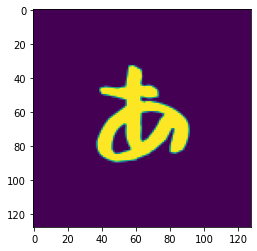

In [30]:
plt.imshow(np_img)

In [36]:
non_zeros_indices = np_img.nonzero()
type(non_zeros_indices)

tuple

In [37]:
len(non_zeros_indices)

2

In [38]:
len(non_zeros_indices[0])

1640

In [39]:
len(non_zeros_indices[1])

1640

In [40]:
non_zeros_indices

(array([33, 33, 33, ..., 89, 89, 89]), array([56, 57, 58, ..., 54, 55, 56]))

In [47]:
zero_ys, zero_xs = np_img.nonzero()[:2]  # `[:2]` just to be safe

min_x, max_x = min(zero_xs), max(zero_xs)
min_y, max_y = min(zero_ys), max(zero_ys)

# the character dimensions is caculated based on the nonzero pixels
character_width = max_x - min_x
character_height = max_y - min_y

min_x, max_x, min_y, max_y, character_width, character_height

(37, 91, 33, 89, 54, 56)

In [45]:
rgb_canvas = np.stack((np_img,)*3, axis=-1)
rgb_canvas.shape

(128, 128, 3)

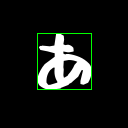

In [60]:
pil_image = Image.fromarray(rgb_canvas)
draw_obj = ImageDraw.Draw(pil_image)

draw_obj.rectangle(
    xy=[(min_x, min_y), (max_x, max_y)],
    outline=(0,255,0),
    width=1,
)

pil_image

In [49]:
pil_image.save('sample_a_with_bounding_box.png', format='PNG')

In [55]:
canvas_size - image_size

64

32 29


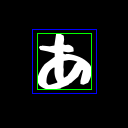

In [62]:
image_offset_top = min_y - int((image_size - character_height)/2)
image_offset_left = min_x - int((image_size - character_width)/2)

print(image_offset_left, image_offset_top)

draw_obj.rectangle(
    xy=[(image_offset_left, image_offset_top), (image_offset_left+image_size, image_offset_top+image_size)],
    outline=(0,0,255),
    width=1,
)

pil_image

In [63]:
pil_image.save('sample_a_with_bounding_boxes_for_exporting_image.png', 'PNG')

48.0 45.0


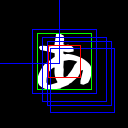

In [59]:
# experiment with image size smaller than font size
image_size = 32
image_offset_top = min_y - (image_size - character_height)/2
image_offset_left = min_x - (image_size - character_width)/2

print(image_offset_left, image_offset_top)

draw_obj.rectangle(
    xy=[(image_offset_left, image_offset_top), (image_offset_left+image_size, image_offset_top+image_size)],
    outline=(255,0,0),
    width=1,
)

pil_image

In [66]:
file_list = os.listdir(LOG_DIRECTORY)
file_list

['1586661863.311972-runtime.log',
 '1586662042.1526327-runtime.log',
 '1586662082.3868406-runtime.log',
 '1586662097.7665117-runtime.log',
 '1586676971.023995-runtime.log',
 '1586677160.823435-runtime.log',
 '1586691725.5852675-runtime.log',
 '1586691782.888618-runtime.log']

In [72]:
logs = []

for filename in file_list:
    if not LOG_SUFFIX in filename:
        print(f'[WARNING] Skipping file {filename}.')
        continue

    filepath = os.path.join(LOG_DIRECTORY, filename)

    try:
        log_data = pd.read_csv(filepath, sep=COLUMN_SEPARATOR, names=('method_name', 'execution_time'))
    except:
        print(f'[WARNING] Skipping incompatible format {filename}!')
        continue

    ts = float(filename.replace(LOG_SUFFIX, ''))
    log_file = LogFile(filename, ts, log_data)
    logs.append(log_file)

logs.sort(key=lambda x: x.ts)

In [73]:
logs

[('2020-04-12_03-24-23', '1586661863.311972-runtime.log'),
 ('2020-04-12_03-27-22', '1586662042.1526327-runtime.log'),
 ('2020-04-12_03-28-02', '1586662082.3868406-runtime.log'),
 ('2020-04-12_03-28-17', '1586662097.7665117-runtime.log'),
 ('2020-04-12_07-36-11', '1586676971.023995-runtime.log'),
 ('2020-04-12_07-39-20', '1586677160.823435-runtime.log'),
 ('2020-04-12_11-42-05', '1586691725.5852675-runtime.log'),
 ('2020-04-12_11-43-02', '1586691782.888618-runtime.log')]

In [82]:
log = logs[-1]
data = log.data
data

,method_name,execution_time
0,fetch_font,0.000296
1,fetch_font,0.001524
2,fetch_font,0.000408
3,fetch_font,0.000120
4,fetch_font,0.000225
...,...,...
6449,is_support,0.022821
6450,is_support,0.023367
6451,is_support,0.023174
6452,is_support,0.023229


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc80d1b4a8>]],
      dtype=object)

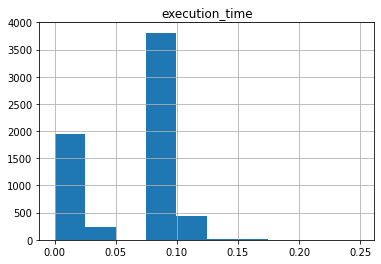

In [84]:
data.hist()

In [83]:
data.execution_time.sum()

436.96581292152405

In [100]:
np_data = data.to_numpy()
np_data

array([['fetch_font', 0.0002961158752441406],
       ['fetch_font', 0.0015244483947753904],
       ['fetch_font', 0.00040841102600097656],
       ...,
       ['is_support', 0.023173809051513672],
       ['is_support', 0.023229122161865238],
       ['is_support', 0.02833890914916992]], dtype=object)

In [101]:
np_data.shape

(6454, 2)

In [103]:
for row in np_data:
    print(row)
    method_name, execution_time = row[:2]
    print(method_name, execution_time)
    break

['fetch_font' 0.0002961158752441406]
fetch_font 0.0002961158752441406


In [86]:
g = data.groupby('method_name')
g

In [90]:
execution_time_by_method_name = g.sum()
execution_time_by_method_name

,execution_time
method_name,
fetch_font,0.020285
is_support,436.945528


In [98]:
execution_time_by_method_name

,execution_time
method_name,
fetch_font,0.020285
is_support,436.945528


In [96]:
execution_time_by_method_name.to_numpy()

array([[2.02851295e-02],
       [4.36945528e+02]])

# 3 plots

- Plot the total amount of time for each methods
- Plot the number of calls for each methods
- Plot max, min, and avg for each methods

In [110]:
func_data = {}

for row in np_data:
    func_name, exec_time = row[:2]
    if func_name in func_data:
        func_data[func_name]['num_calls'] += 1
        func_data[func_name]['total_exec_time'] += exec_time

        last_min = func_data[func_name]['min']
        func_data[func_name]['min'] = min(exec_time, last_min)

        last_max = func_data[func_name]['max']
        func_data[func_name]['max'] = max(exec_time, last_max)
    else:
        func_data[func_name] = {
            'num_calls': 1,
            'total_exec_time': exec_time,
            'min': exec_time,
            'max': exec_time,
        }

for func_name in func_data:
    # calculate and average
    total_exec_time = func_data[func_name]['total_exec_time']
    num_calls = func_data[func_name]['num_calls']

    func_data[func_name]['avg'] = total_exec_time / num_calls
    
func_data

{'fetch_font': {'num_calls': 46,
  'total_exec_time': 0.02028512954711914,
  'min': 9.989738464355467e-05,
  'max': 0.0018551349639892574,
  'avg': 0.0004409810771112857},
 'is_support': {'num_calls': 6408,
  'total_exec_time': 436.94552779197693,
  'min': 0.01925802230834961,
  'max': 0.2489619255065918,
  'avg': 0.06818750433707504}}

In [107]:
for key in func_data:
    print(key)

fetch_font
is_support


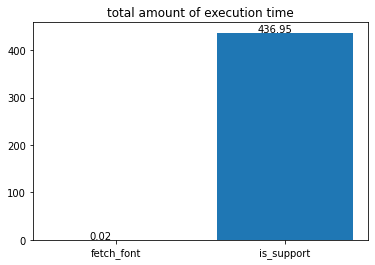

In [115]:
plt.title('total amount of execution time')
names = []
values = []
for func_name in func_data:
    names.append(func_name)
    values.append(func_data[func_name]['total_exec_time'])

bars = plt.bar(names, values)
# show values on top of bars
# https://stackoverflow.com/questions/53066633/python-how-to-show-values-on-top-of-bar-plot
text_height_delta = max(values) * .005
for idx, bar in enumerate(bars):
    y = bar.get_height()
    plt.text(
        x=bar.get_x() + bar.get_width()*0.3,
        y=bar.get_height() + text_height_delta,
        s=f'{values[idx]:.2f}',
    )

In [116]:
bars

<BarContainer object of 2 artists>

In [117]:
type(bars)

matplotlib.container.BarContainer

In [119]:
x = np.arange(8)
x

array([0, 1, 2, 3, 4, 5, 6, 7])

In [120]:
x * 2

array([ 0,  2,  4,  6,  8, 10, 12, 14])

In [121]:
class TerminateColor:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'

In [122]:
print(f'{TerminateColor.HEADER}Header{TerminateColor.ENDC}')
print(f'{TerminateColor.OKBLUE}OKBLUE{TerminateColor.ENDC}')
print(f'{TerminateColor.OKGREEN}OKGREEN{TerminateColor.ENDC}')
print(f'{TerminateColor.WARNING}WARNING{TerminateColor.ENDC}')
print(f'{TerminateColor.FAIL}FAIL{TerminateColor.ENDC}')

Header
OKBLUE
OKGREEN
WARNING
FAIL
